In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using StatsPlots   # 提供 boxplot，基于 Plots
using JuMP
using MosekTools
using JLD2
using Plots
using DataFrames, Colors
include("ETO.jl")
include("RO.jl")
include("Data.jl")
include("Estimate.jl")
include("Performance.jl")

greedy_search_optimal_price (generic function with 1 method)

In [2]:
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(grand_pa_dir, "/Data/")
if !isdir(data_dir)
    mkpath(data_dir)
end

In [3]:
function plot_boxplot(RO_coef_chosen,Rev_ETO,Rev_RO)
    # # 示例：假设你已有这些数据
    RO_coef_chosen = RO_coef_all[1:5]
    data   = [Rev_ETO, [Rev_RO["RO_coef=$(RO_coef)"] for RO_coef in RO_coef_chosen]...]
    labels = ["ETO"; ["RO_$(RO_coef)" for RO_coef in RO_coef_chosen]]
    # --- 1) 展开成长表 ---
    df = DataFrame(
        value = vcat(data...),
        group = repeat(labels, inner = length(data[1]))
    )

    mycolors = palette(:tab10)[1:length(labels)]   # tab10 最多10个颜色

    # --- 3) 绘制箱线图 ---
    @df df boxplot(:group, :value;
        group = :group,
        palette = mycolors,
        legend = false,
        ylabel = "Revenue",
        # title = "Revenue Distribution"
    )

    # --- 4) 计算均值 ---
    means = combine(groupby(df, :group), :value => mean => :mean_val)

    # --- 5) 绘制均值点（直接用字符串标签保证位置居中） ---
    for (i, row) in enumerate(eachrow(means))
        scatter!([row.group], [row.mean_val];
            color = mycolors[i],
            marker = (:star5, 10),
            label = "")
    end

    # --- 6) 绘制均值连线（这里必须把类别转为数值 1:N） ---
    plot!(1:length(labels), means.mean_val;
        seriestype = :line,
        color = :black,
        lw = 2,
        ls = :dash,
        label = "Mean trend"
    )
end

plot_boxplot (generic function with 1 method)

## Evaluate

#### Baseline Parameters

In [4]:
project_name = "Assortment_Pricing_Simulated_Data/"
seed = 1;
N = 5;
N_u = 1;
K = 10;
S_train = 100;
S_test = 1000;
max_offdiag = 0.3;
P_bar = 1.0;
iterations = 100;
RO_coef_all = [0.0,0.01,0.05,0.1,0.12,0.14,0.16,0.18,0.2];

### S_train = 100,offdiag_sign = "mix",max_offdiag = 0.3;

In [5]:
S_train = 100;
offdiag_sign = "mix";
max_offdiag = 0.3;
sub_file_name = "N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_offdiag_sign=$(offdiag_sign)_max_offdiag=$(max_offdiag)/"
this_data_file = string(data_dir,project_name,sub_file_name);

In [6]:
Params = load(string(this_data_file, "Params.jld2"));
Input_Data = load(string(this_data_file, "Input_Data.jld2"));
RST_Oracle = load(string(this_data_file, "RST_Oracle.jld2"));
RST_ETO = load(string(this_data_file, "RST_ETO.jld2"));
RST_RO = load(string(this_data_file, "RST_RO.jld2"));

In [7]:
Rev_Oracle = [RST_Oracle["iter=$(iter)_Rev"] for iter in 1:iterations];
Rev_ETO = [RST_ETO["iter=$(iter)_Rev"] for iter in 1:iterations];
Rev_RO = Dict();
for RO_coef in RO_coef_all
    RST_RO_this = RST_RO["RO_coef=$(RO_coef)"]
    Rev_RO["RO_coef=$(RO_coef)"] = [RST_RO_this["iter=$(iter)_Rev"] for iter in 1:iterations];
end

println("Mean Rev_Oracle: ", mean(Rev_Oracle));
println("Mean Rev_ETO: ", mean(Rev_ETO));
Rev_RO_Avg = [mean(Rev_RO["RO_coef=$(RO_coef)"]) for RO_coef in RO_coef_all];
println("Mean Rev_RO: ", Rev_RO_Avg);

Mean Rev_Oracle: 0.7011601117394263
Mean Rev_ETO: 0.611673017549343
Mean Rev_RO: [0.611673017549343, 0.6141989463015668, 0.6217102973106133, 0.6269039910054761, 0.6246374494393756, 0.6270151709468079, 0.6256411407112129, 0.6252223527710696, 0.6227185372331098]


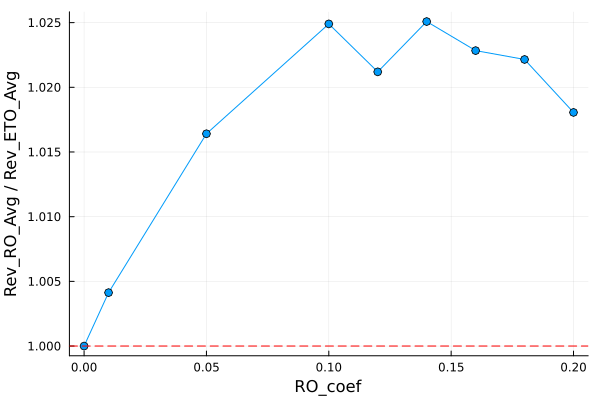

In [8]:
ratio = Rev_RO_Avg ./ mean(Rev_ETO)
plot(RO_coef_all, ratio, marker=:o, xlabel="RO_coef", ylabel="Rev_RO_Avg / Rev_ETO_Avg", legend=false)
hline!([1.0], linestyle=:dash, color=:red, label="y=1.0")

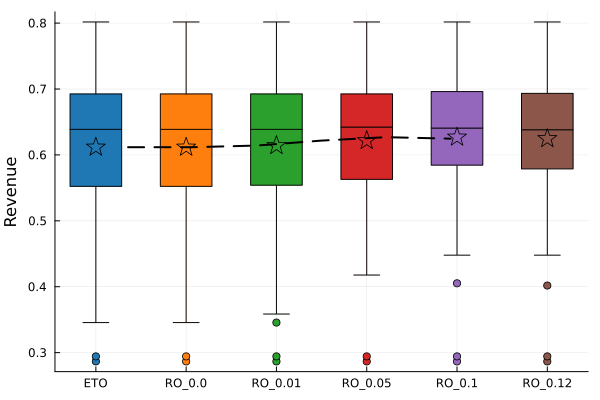

In [9]:
RO_coef_chosen = RO_coef_all[1:5]
plot_boxplot(RO_coef_chosen,Rev_ETO,Rev_RO)

### S_train = 200,offdiag_sign = "mix",max_offdiag = 0.3;

In [ ]:
S_train = 200;
offdiag_sign = "mix";
max_offdiag = 0.3;
sub_file_name = "N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_offdiag_sign=$(offdiag_sign)_max_offdiag=$(max_offdiag)/"
this_data_file = string(data_dir,project_name,sub_file_name)

In [ ]:
Params = load(string(this_data_file, "Params.jld2"));
RST_Oracle = load(string(this_data_file, "RST_Oracle.jld2"));
RST_ETO = load(string(this_data_file, "RST_ETO.jld2"));
RST_RO = load(string(this_data_file, "RST_RO.jld2"));

In [ ]:
Rev_Oracle = [RST_Oracle["iter=$(iter)_Rev"] for iter in 1:iterations];
Rev_ETO = [RST_ETO["iter=$(iter)_Rev"] for iter in 1:iterations];
Rev_RO = Dict();
for RO_coef in RO_coef_all
    RST_RO_this = RST_RO["RO_coef=$(RO_coef)"]
    Rev_RO["RO_coef=$(RO_coef)"] = [RST_RO_this["iter=$(iter)_Rev"] for iter in 1:iterations];
end

println("Mean Rev_Oracle: ", mean(Rev_Oracle));
println("Mean Rev_ETO: ", mean(Rev_ETO));
Rev_RO_Avg = [mean(Rev_RO["RO_coef=$(RO_coef)"]) for RO_coef in RO_coef_all];
println("Mean Rev_RO: ", Rev_RO_Avg);

### S_train = 100,offdiag_sign = "positive",max_offdiag = 0.3;

In [ ]:
S_train = 100;
offdiag_sign = "positive";
max_offdiag = 0.3;
sub_file_name = "N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_offdiag_sign=$(offdiag_sign)_max_offdiag=$(max_offdiag)/"

In [ ]:
this_data_file = string(data_dir,project_name,sub_file_name);
Params = load(string(this_data_file, "Params.jld2"));
RST_Oracle = load(string(this_data_file, "RST_Oracle.jld2"));
RST_ETO = load(string(this_data_file, "RST_ETO.jld2"));
RST_RO = load(string(this_data_file, "RST_RO.jld2"));

In [ ]:
Rev_Oracle = [RST_Oracle["iter=$(iter)_Rev"] for iter in 1:iterations];
Rev_ETO = [RST_ETO["iter=$(iter)_Rev"] for iter in 1:iterations];
Rev_RO = Dict();
for RO_coef in RO_coef_all
    RST_RO_this = RST_RO["RO_coef=$(RO_coef)"]
    Rev_RO["RO_coef=$(RO_coef)"] = [RST_RO_this["iter=$(iter)_Rev"] for iter in 1:iterations];
end

In [ ]:
println("Mean Rev_Oracle: ", mean(Rev_Oracle));
println("Mean Rev_ETO: ", mean(Rev_ETO));
Rev_RO_Avg = [mean(Rev_RO["RO_coef=$(RO_coef)"]) for RO_coef in RO_coef_all];
println("Mean Rev_RO: ", Rev_RO_Avg);

In [ ]:
ratio = Rev_RO_Avg ./ mean(Rev_ETO)
plot(RO_coef_all, ratio, marker=:o, xlabel="RO_coef", ylabel="Rev_RO_Avg / mean(Rev_ETO)", legend=false)
hline!([1.0], linestyle=:dash, color=:red, label="y=1.0")

In [ ]:
RO_coef_chosen = RO_coef_all[1:5]
plot_boxplot(RO_coef_chosen,Rev_ETO,Rev_RO)

### offdiag is negative

In [ ]:
offdiag_sign = "negative";
sub_file_name = "N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_offdiag_sign=$(offdiag_sign)_max_offdiag=$(max_offdiag)/"

In [ ]:
this_data_file = string(data_dir,project_name,sub_file_name);
Params = load(string(this_data_file, "Params.jld2"));
RST_Oracle = load(string(this_data_file, "RST_Oracle.jld2"));
RST_ETO = load(string(this_data_file, "RST_ETO.jld2"));
RST_RO = load(string(this_data_file, "RST_RO.jld2"));

In [ ]:
Rev_Oracle = [RST_Oracle["iter=$(iter)_Rev"] for iter in 1:iterations];
Rev_ETO = [RST_ETO["iter=$(iter)_Rev"] for iter in 1:iterations];
Rev_RO = Dict();
for RO_coef in RO_coef_all
    RST_RO_this = RST_RO["RO_coef=$(RO_coef)"]
    Rev_RO["RO_coef=$(RO_coef)"] = [RST_RO_this["iter=$(iter)_Rev"] for iter in 1:iterations];
end

In [ ]:
ratio = Rev_RO_Avg ./ mean(Rev_ETO)
plot(RO_coef_all, ratio, marker=:o, xlabel="RO_coef", ylabel="Rev_RO_Avg / mean(Rev_ETO)", legend=false)
hline!([1.0], linestyle=:dash, color=:red, label="y=1.0")

### S_train = 100,offdiag_sign = "positive",max_offdiag = 1.0;

In [ ]:
S_train = 100;
offdiag_sign = "mix";
max_offdiag = 1.0;
sub_file_name = "N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_offdiag_sign=$(offdiag_sign)_max_offdiag=$(max_offdiag)/"
this_data_file = string(data_dir,project_name,sub_file_name);

In [ ]:
Params = load(string(this_data_file, "Params.jld2"));
RST_Oracle = load(string(this_data_file, "RST_Oracle.jld2"));
RST_ETO = load(string(this_data_file, "RST_ETO.jld2"));
RST_RO = load(string(this_data_file, "RST_RO.jld2"));

### S_train = 200,offdiag_sign = "positive",max_offdiag = 1.0;

In [ ]:
S_train = 200;
offdiag_sign = "mix";
max_offdiag = 1.0;
sub_file_name = "N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_offdiag_sign=$(offdiag_sign)_max_offdiag=$(max_offdiag)/"
this_data_file = string(data_dir,project_name,sub_file_name);

In [ ]:
Params = load(string(this_data_file, "Params.jld2"));
RST_Oracle = load(string(this_data_file, "RST_Oracle.jld2"));
RST_ETO = load(string(this_data_file, "RST_ETO.jld2"));
RST_RO = load(string(this_data_file, "RST_RO.jld2"));

In [ ]:
RO_coef_all = [0.0,0.01,0.05,0.1,0.12];

In [ ]:
Rev_Oracle = [RST_Oracle["iter=$(iter)_Rev"] for iter in 1:iterations];
Rev_ETO = [RST_ETO["iter=$(iter)_Rev"] for iter in 1:iterations];
Rev_RO = Dict();
for RO_coef in RO_coef_all
    RST_RO_this = RST_RO["RO_coef=$(RO_coef)"]
    Rev_RO["RO_coef=$(RO_coef)"] = [RST_RO_this["iter=$(iter)_Rev"] for iter in 1:iterations];
end

In [ ]:
println("Mean Rev_Oracle: ", mean(Rev_Oracle));
println("Mean Rev_ETO: ", mean(Rev_ETO));
Rev_RO_Avg = [mean(Rev_RO["RO_coef=$(RO_coef)"]) for RO_coef in RO_coef_all];
println("Mean Rev_RO: ", Rev_RO_Avg);

In [ ]:
ratio = Rev_RO_Avg ./ mean(Rev_ETO)
plot(RO_coef_all, ratio, marker=:o, xlabel="RO_coef", ylabel="Rev_RO_Avg / mean(Rev_ETO)", legend=false)
hline!([1.0], linestyle=:dash, color=:red, label="y=1.0")